In [262]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import itertools 
# import plotly.express as pltly
# import plotly
import pandas as pd
from functools import partial
import networkx as net
from utils import TwoSectionH
# import plotly.graph_objects as go

In [2]:
np.set_printoptions(suppress = True)

parameters for $\mu-L$ convergence
* $\mu = 2\lambda$       regularization parameter

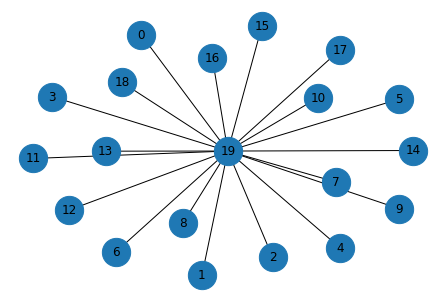

In [286]:
K = 20
# train_images=train_images.reshape((60000,784),order='C')
# SampleCov=[(train_images[sample_indices[i]].T @ train_images[sample_indices[i]]) / len(sample_indices[i]) for i in range(K)]
# lambdaSampleCov=[np.linalg.eigvalsh(SampleCov[i]).reshape((784,1)) for i in range(K)]
# E = 1./2*(np.eye(K) - np.ones((K,1)) @ np.ones((1,K)) / K)
# lambdaE=np.linalg.eigvalsh(E).reshape((K,1))
# lambda_base = [max(.5*lambdaSampleCov[i]).squeeze() for i in range(K)]
lamda = .002
# L = max(lambda_base) + lamda
L = .1581 + .002
mu = lamda
kappa = L / mu
gb = .1 # as the norm bound G for gradient
bar_sigma_sqr= 1.
a0 = 20 # initial distance between the average model parameter and the optimal one


seeds = iter(range(1000))
prob = 0.5
alg_connect = 0
while alg_connect < 1e-4:
#     # Generate a star-based ER graph
#     ER = net.erdos_renyi_graph(K-1, 0.1, seed = next(seeds))
#     ER.add_node(K-1)
    G = net.star_graph(reversed(range(K)))
#     G.add_edges_from(ER.edges())

#     # Generate an arbitrary ER graph
#     G = net.erdos_renyi_graph(K, p, seed = next(seeds))

#     # Generate a chain (cycle) graph
#     G = net.cycle_graph(K)
#     G.remove_edge(0, K-1)
#     # Base an ER graph with prob on the chain graph to improve the spectral gap delta
#     ER = net.erdos_renyi_graph(K, prob, seed = next(seeds))
#     G.add_edges_from(ER.edges())

#     # Generate a 2-D torus (5-by-4)
#     G = net.grid_2d_graph(5, 4, periodic=True)
#     mapping = {(m,n):4*m+n for m, n in G.nodes()}
#     _ = net.relabel_nodes(G, mapping, copy=False)

#     # Generate a complete graph
#     G = net.complete_graph(K)

    LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
    E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
    alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
pos = net.spring_layout(G)
net.draw(G, pos, with_labels = True, node_size = 800, edge_size = 1000, font_size = 12)

delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)


# The optimum a' adpative to other paramters to minimize the upper-bound for optimality gap
# a_prime = ( (169 * 2 * gb**2 * delta) / (mu**2 * c**2 * rho**2 * (2-omega) * m**2/d * zeta_ini) ) ** (1/3)
# when p(t) >= p_ini for the whole training iterations
# a_prime = ( (169 * 2 * gb**2 * 4 * p_ini) / (mu**2 * c**2 * rho**2 * (2-omega) * m**2/d * zeta_ini**2) ) ** (1/3)

In [287]:
delta

0.09523809523809479

In [288]:
beta

1.9047619047619044

In [186]:
barP = 2e-5
N_0 = 10 ** (-169/10) * 1e-3
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
M = 10

In [187]:
10 * np.log10(barP/N_0 * M * A0 * ( 125 /d0) ** -gamma)

49.66648346753688

In [188]:
np.log10(2e-5)

-4.698970004336019

In [4]:
L

0.1601

*The parameters in the following block is applicable to the upper-bound for the digital scheme only.*

In [264]:
np.random.seed(2)

num_lack_max = 4
num_lack = np.random.randint(0,num_lack_max+1,(K,))
for k in range(K):
    arr = np.ones((10,))
    arr[:num_lack[k]] = 0
    np.random.shuffle(arr)
        
d_min = 50
d_max = 200
rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
theta = 2 * np.pi * np.random.rand(K,1)
D = 125 * np.ones((K, K)) # mimic the effect of the same pathloss
# D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
# # Fill in D[i,i] some non-zero value to avoid Inf in PL
# for i in range(K):
#     if i:
#         D[i,i] = D[i,i-1]
#     else:
#         D[i,i] = D[i,i+1]
A0 = 10 ** (-3.35)
d0 = 1
gamma = 3.76
# PL = A0 * ((D / d0) ** (-gamma))

d = 7850
# N = 7943
# barP = 2e-6
# M = 10 # the chromatic number for the digital scheme
N0 = 10 ** (-169/10) * 1e-3
c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
b = 64

funcG= lambda barP, M, N, n, i:np.exp(-( np.power(2, n*b*M / N) - 1 ) / (barP / N0) * c_array[i] / (M * A0) )
# omega = min( 1- funcG(barP, M, N, 1, i) + sum(funcG(barP, M, N, n, i) for n in range(1,d+1)) / d for i in range(K) )
p = lambda delta, beta, omega: delta**2 * omega / (2 * (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega))
zeta0 = lambda delta, beta, omega: delta * omega / (16*delta + delta**2 + 4*beta**2 + 2*delta*beta**2 - 8*delta*omega)

In [267]:
D[0]

array([125., 125., 125., 125., 125., 125., 125., 125., 125., 125., 125.,
       125., 125., 125., 125., 125., 125., 125., 125., 125.])

In [16]:
delta

0.3071035580555791

In [17]:
beta

1.692896441944421

In [122]:
num_lack

array([0, 0, 3, 2, 3, 0, 2, 1, 3, 2, 4, 4, 4, 3, 4, 2, 3, 3, 2, 1])

Theorem 0 (No Commun.)
$$\mathbb{E}[f(x^{(T)}_{avg})-f(x^\ast)]\le\frac{\mu}{3.25}\frac{a^3-3.25a^2}{S_T}v_e^{(0)} + \frac{1.625T(T+2a)}{\mu S_T}\frac{{\bar\sigma}^2}{K}+1.5L\left(1+\frac{1}{K}\right)^2\frac{4}{\mu^2}G^2$$

Theorem 1 
$$\mathbb{E}[f(x^{(T)}_{avg})-f(x^\ast)]\le\frac{\mu}{3.25}\frac{a^3-3.25a^2}{S_T}v_e^{(0)} + \frac{1.625T(T+2a)}{\mu S_T}\frac{{\bar\sigma}^2}{K}+\frac{158.45\times 24LT}{\mu^2(p(\delta,\omega))^2S_T}G^2$$

Theorem 2 (modification of Theorem 19 [A.Koloskova *et al.* 19])
$$\mathbb{E}[f(x^{(T)}_{avg})-f(x^\ast)]\le\frac{\mu}{3.25}\frac{a^3-3.25a^2}{S_T}v_e^{(0)}+\frac{1.625T(T+2a)}{\mu S_T}\frac{\bar\sigma^2}{K}+\frac{158.45\left(24G^2+\frac{A(\delta,\omega)}{K}\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}\right)LT}{\mu^2(p^{(T)}(\delta,\omega))^2 S_T}+C(\delta,\omega)$$
in which $p^{(t)}(\delta,\omega)=\min\{\tilde p^{(t)}(\delta,\omega), p(\delta,\omega)\}$ with  
$$\tilde p^{(t)}(\delta,\omega)=\frac{\delta\zeta_0}{\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}t/a^\prime+1}-\left(\frac{\delta^2}{4}+\frac{2}{\omega}\beta^2\right)\frac{\zeta_0^2}{\big(\sqrt[\leftroot{-2}\uproot{4}4]{\tilde N_{0,T}}t/a^\prime+1\big)^2}, $$ and 
$$C(\delta,\omega)=\frac{1}{K^2}(\zeta_0(\delta,\omega)a^\prime)^2\omega^2d\frac{\mu}{3.25}\sqrt{\tilde N_{0,T}}$$
$$A(\delta,\omega)=\delta(\zeta_0(\delta,\omega)a^\prime)^3(2-\omega)\omega^2d\left(\frac{\mu}{3.25}\right)^2$$

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde\theta_T) - F^\ast$ vs iterations $T$**

C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:75: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


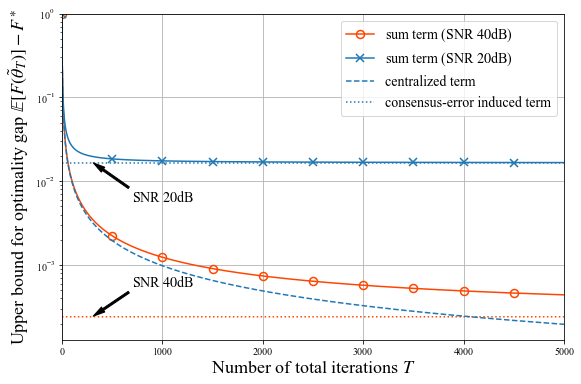

In [156]:
gb = 1
a = 3.5e7
# M = 8 # the chromatic number for the digital scheme
N = 10000
# opt = 0.41

Tmax = 5e3
T_array = np.arange(1,Tmax)
sT = np.cumsum((a+T_array)**2)
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
M = 8 # the chromatic number for 2-D torus
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')


barP = 2e-6

omega = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og1/og1[0], color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (SNR $40$dB)')

# og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K)
# # plt.semilogy(T_array, og2_partI/og2[0], ls = '--', color = 'C0', label = r'$\mathcal{O}\left(\frac{\bar\sigma^2}{\mu KT}+\frac{\bar\sigma^2}{\mu KT^2}+\frac{\mu}{T^3}\right)$')
# plt.semilogy(T_array, og1_partI/og1[0], ls = '--', color = 'C0', label = r'centralized term')

og1_partII = (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'$\mathcal{O}\left(\frac{LG^2}{\mu^2(p(\delta,\omega))^2T^2}\right)$')
plt.semilogy(T_array, og1_partII/og1[0], ls = ':', color = 'orangered')


barP = 2e-8

omega2 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega2) **2 * sT) * gb**2
plt.semilogy(T_array, og2/og2[0], color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (SNR $20$dB)')

og2_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K)
# plt.semilogy(T_array, og2_partI/og2[0], ls = '--', color = 'C0', label = r'$\mathcal{O}\left(\frac{\bar\sigma^2}{\mu KT}+\frac{\bar\sigma^2}{\mu KT^2}+\frac{\mu}{T^3}\right)$')
plt.semilogy(T_array, og2_partI/og2[0], ls = '--', color = 'C0', label = r'centralized term')

og2_partII = (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega2) **2 * sT) * gb**2
# plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'$\mathcal{O}\left(\frac{LG^2}{\mu^2(p(\delta,\omega))^2T^2}\right)$')
plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'consensus-error induced term')

plt.xlabel(r'Number of total iterations $T$', fontsize = 18)
plt.ylabel(r'Upper bound for optimality gap $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((0, 5000))
plt.ylim((0, 1))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'SNR $20$dB',
            xy = (300, 0.017), xycoords = 'data',
            xytext = (40, -40), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'SNR $40$dB',
            xy = (300, 0.00024), xycoords = 'data',
            xytext = (40, 30), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_SNR.eps',format='eps', dpi=600)
plt.show()

In [151]:
(og2_partII[0]-og2_partII[-1])/og2[0]

0.12916262818831806

In [178]:
barP = 0.7e-8
omega = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )

In [180]:
max(5/p(delta,beta,omega), 13*L/mu)

2958543.2713558995

In [152]:
og2_partII/og2[0]

array([0.54192247, 0.54192231, 0.54192216, ..., 0.41276005, 0.41275995,
       0.41275984])

In [169]:
np.log10(.7e-8)

-8.154901959985743

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ vs SNR at $T=2000$**

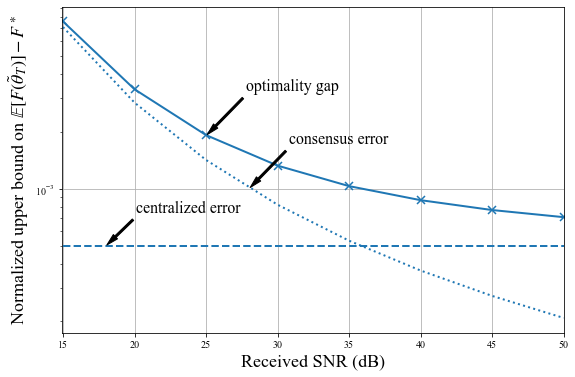

In [430]:
gb = 1
a = 2.0e7
# M = 8 # the chromatic number for the digital scheme
N = 10000
# opt = 0.41

T0 = 0
T1 = 2e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
M = 8 # the chromatic number for 2-D torus
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')


barP_array = np.logspace(-8.2, -4.7, num = 8)
og1_array = np.ones(barP_array.shape)
og1_ini_array = np.ones(barP_array.shape)
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_array = og1_partI * np.ones(barP_array.shape)
og1_partII_array= np.ones(barP_array.shape)
for n, barP in zip(range(len(barP_array)), barP_array):
    omega = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
    og1_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * 24 * L * T1) / (mu**2 * p(delta,beta,omega) **2 * sT1) * gb**2
#     plt.semilogy(T_array, og1/og1[0], color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (SNR $40$dB)')

    og1_partII_array[n] = (158.45 * 24 * L * T1) / (mu**2 * p(delta,beta,omega) **2 * sT1) * gb**2
    # plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'$\mathcal{O}\left(\frac{LG^2}{\mu^2(p(\delta,\omega))^2T^2}\right)$')
#     plt.semilogy(T_array, og1_partII/og1[0], ls = ':', color = 'orangered')

    og1_ini_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * 24 * L * T0) / (mu**2 * p(delta,beta,omega) **2 * sT0) * gb**2
   
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_array/og1_ini_array, lw = 2.0, color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, label = r'sum term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partI_array/og1_ini_array, lw = 2.0, ls = '--', color = 'C0', label = r'centralized term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partII_array/og1_ini_array, lw = 2.0, ls = ':', color = 'C0', label = r'consensus-error induced term')

plt.xlabel(r'Received SNR (dB)', fontsize = 18)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((14.9, 50))
# plt.ylim((0, 0.02))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'optimality gap',
            xy = (25, 0.0019), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'consensus error',
            xy = (28, 0.0010), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'centralized error',
            xy = (18, 0.0005), xycoords = 'data',
            xytext = (30, 33), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_SNR_small_T.eps',format='eps', dpi=600)
plt.show()      

In [431]:
(og1_array/og1_ini_array).max()

0.007608833258560505

In [411]:
barP = barP_array[0]
omega = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta1,beta1,omega1), 13 * L/mu)}')

20000000.0 | 39869.49787771601


In [422]:
45*0.75

33.75

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ vs SNR at $T=5000$**

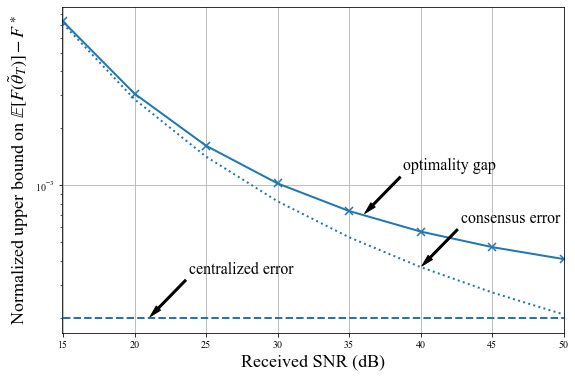

In [436]:
gb = 1
a = 2.0e7
# M = 8 # the chromatic number for the digital scheme
N = 10000
# opt = 0.41

T0 = 0 # the initial iteration used to evaluate the upper bounds for normalization
T1 = 5e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0]
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
M = 8 # the chromatic number for 2-D torus
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')


barP_array = np.logspace(-8.2, -4.7, num = 8)
og1_array = np.ones(barP_array.shape)
og1_ini_array = np.ones(barP_array.shape)
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_array = og1_partI * np.ones(barP_array.shape)
og1_partII_array= np.ones(barP_array.shape)
for n, barP in zip(range(len(barP_array)), barP_array):
    omega = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
    og1_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
    1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
    (158.45 * 24 * L * T1) / (mu**2 * p(delta,beta,omega) **2 * sT1) * gb**2
#     plt.semilogy(T_array, og1/og1[0], color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (SNR $40$dB)')

    og1_partII_array[n] = (158.45 * 24 * L * T1) / (mu**2 * p(delta,beta,omega) **2 * sT1) * gb**2
    # plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'$\mathcal{O}\left(\frac{LG^2}{\mu^2(p(\delta,\omega))^2T^2}\right)$')
#     plt.semilogy(T_array, og1_partII/og1[0], ls = ':', color = 'orangered')

    og1_ini_array[n] = mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
    1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
    (158.45 * 24 * L * T0) / (mu**2 * p(delta,beta,omega) **2 * sT0) * gb**2
   
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_array/og1_ini_array, lw = 2.0, color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, label = r'sum term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partI_array/og1_ini_array, lw = 2.0, ls = '--', color = 'C0', label = r'centralized term')
plt.semilogy(15 + 10*np.log10(barP_array/barP_array[0]), og1_partII_array/og1_ini_array, lw = 2.0, ls = ':', color = 'C0', label = r'consensus-error induced term')

plt.xlabel(r'Received SNR (dB)', fontsize = 18)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((14.9, 50))
# plt.ylim((0, 0.02))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'optimality gap',
            xy = (36, 0.0007), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'consensus error',
            xy = (40, 0.00037), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'centralized error',
            xy = (21, 0.0002), xycoords = 'data',
            xytext = (40, 45), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_SNR_large_T.eps',format='eps', dpi=600)
plt.show()  

In [434]:
(og1_array/og1_ini_array)[4]

0.0007323160962959145

**Evaluate the analytical upper-bound (*relative*) for $F({\bar{\theta}}^{(t)}) - F^\ast$ with varying toplogies**

C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:87: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


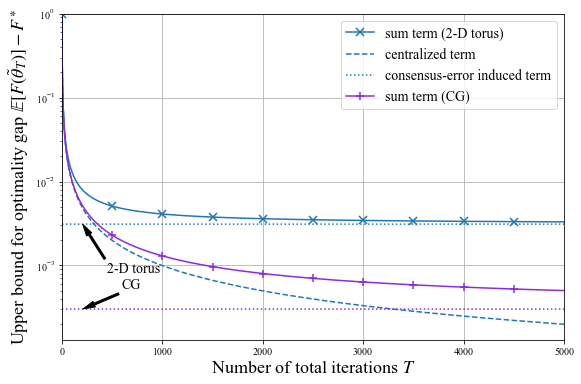

In [86]:
gb = 1
a = 2.5e7
# M = 8 # the chromatic number for the digital scheme
N = 10000
# opt = 0.41

Tmax = 5e3
T_array = np.arange(1,Tmax)
sT = np.cumsum((a+T_array)**2)
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
M = 8 # the chromatic number for 2-D torus

barP = 2e-7

omega = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og1/og1[0], color = 'C0', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (2-D torus)')

og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K)
# plt.semilogy(T_array, og2_partI/og2[0], ls = '--', color = 'C0', label = r'$\mathcal{O}\left(\frac{\bar\sigma^2}{\mu KT}+\frac{\bar\sigma^2}{\mu KT^2}+\frac{\mu}{T^3}\right)$')
plt.semilogy(T_array, og1_partI/og1[0], ls = '--', color = 'C0', label = r'centralized term')

og1_partII = (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'$\mathcal{O}\left(\frac{LG^2}{\mu^2(p(\delta,\omega))^2T^2}\right)$')
plt.semilogy(T_array, og1_partII/og1[0], ls = ':', color = 'C0', label = r'consensus-error induced term')


# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
M = 20 # the chromatic number for CG

omega2 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta2,beta2,omega2) **2 * sT) * gb**2
plt.semilogy(T_array, og2/og2[0], color = 'blueviolet', marker = '+', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'sum term (CG)')

# og2_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K)
# # plt.semilogy(T_array, og2_partI/og2[0], ls = '--', color = 'C0', label = r'$\mathcal{O}\left(\frac{\bar\sigma^2}{\mu KT}+\frac{\bar\sigma^2}{\mu KT^2}+\frac{\mu}{T^3}\right)$')
# plt.semilogy(T_array, og2_partI/og2[0], ls = '--', color = 'blueviolet')

og2_partII = (158.45 * 24 * L * T_array) / (mu**2 * p(delta2,beta2,omega2) **2 * sT) * gb**2
# plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'C0', label = r'$\mathcal{O}\left(\frac{LG^2}{\mu^2(p(\delta,\omega))^2T^2}\right)$')
plt.semilogy(T_array, og2_partII/og2[0], ls = ':', color = 'blueviolet')


# # no communication with bounded consensus error derived as a result of (expected) norm bound for gradients
# ogLocal = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) +\
# 1.5 * L * (1 + 1./K)**2 * (4 / mu**2) * gb**2
# plt.semilogy(T_array, ogLocal, color = 'tab:green')


plt.xlabel(r'Number of total iterations $T$', fontsize = 18)
plt.ylabel(r'Upper bound for optimality gap $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((0, 5000))
plt.ylim((0, 1))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'2-D torus',
            xy = (200, .0032), xycoords = 'data',
            xytext = (25, -50), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'CG',
            xy = (200, .0003), xycoords = 'data',
            xytext = (40, 20), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'no commun.',
#             xy = (2000, 3201), xycoords = 'data',
#             xytext = (-100, 40), textcoords = 'offset points', fontsize = 14,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'average SNR $12$dB',
#             xy = (3000, 1143), xycoords = 'data',
#             xytext = (-140, 40), textcoords = 'offset points', fontsize = 14,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'average SNR $15$dB',
#             xy = (4200, 525), xycoords = 'data',
#             xytext = (-140, 40), textcoords = 'offset points', fontsize = 14,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_topology.eps',format='eps', dpi=600)
plt.show()

In [67]:
max(5/p(delta,beta,omega), 13 * L/mu)

313775.9306100144

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ for varying topologies at $T=2000$**

130000000.0 | 39869.49787771601
130000000.0 | 243187.19859429664
130000000.0 | 1991440.0055511463


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


130000000.0 | 3204135.348371903


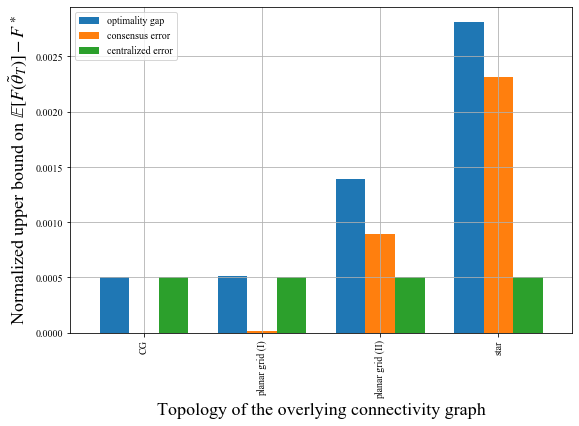

In [455]:
gb = 1
a = 1.3e8
barP = 2e-7
M = K
N = 10000
# opt = 0.41

T0 = 0
T1 = 2e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

og1_list = [] # store the optimality gap
og1_ini_list = [] # sotre the initial optimality gap
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_list = [] # store the centralized error
og1_partII_list = [] # store the consensus error

# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta1 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta1 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega1 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta1,beta1,omega1), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta1,beta1,omega1) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta1,beta1,omega1) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta1,beta1,omega1) **2 * sT0) * gb**2 )


# Generate a 2-D torus (5-by-4, periodic)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega2 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta2,beta2,omega2), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta2,beta2,omega2) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta2,beta2,omega2) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta2,beta2,omega2) **2 * sT0) * gb**2 )


# Generate a 2-D torus (5-by-4, aperiodic)
G = net.grid_2d_graph(5, 4, periodic=False)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta3 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta3 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega3 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta3,beta3,omega3), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta3,beta3,omega3) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta3,beta3,omega3) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta3,beta3,omega3) **2 * sT0) * gb**2 )


# Generate a star graph
G = net.star_graph(reversed(range(K)))
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta4 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta4 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega4 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta4,beta4,omega4), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta4,beta4,omega4) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta4,beta4,omega4) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta4,beta4,omega4) **2 * sT0) * gb**2 )


# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
# E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
# alg_connect = E[1] 
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP
# delta5 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta5 = np.linalg.norm(np.eye(K) - W, ord=2)

# c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
# omega5 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
# print(f'{a} | {max(5/p(delta5,beta5,omega5), 13 * L/mu)}')

# og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
# 1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_partI_list.append( og1_partI )

# og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
# 1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T0) / (mu**2 * p(delta5,beta5,omega5) **2 * sT0) * gb**2 )

df1 = pd.DataFrame(columns = ['optimality gap', 'consensus error', 'centralized error'], 
                   index = ['CG', 'planar grid (I)', 'planar grid (II)', 'star'])
df1['optimality gap'] = np.array(og1_list) / np.array(og1_ini_list)
df1['consensus error'] = np.array(og1_partII_list) /np.array(og1_ini_list)
df1['centralized error'] = np.array(og1_partI_list) / np.array(og1_ini_list)
df1.plot.bar(width=0.75, ax = ax)

plt.xlabel(r'Topology of the overlying connectivity graph', fontsize = 18)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
# plt.xlim((0, 5000))
# plt.ylim((0, 1))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_topology_small_T.eps',format='eps', dpi=600)
plt.show()

In [452]:
df1

,optimality gap,consensus error,centralized error
CG,0.000500,3.579011e-07,0.0005
planar grid (I),0.000513,1.331567e-05,0.0005
planar grid (II),0.001393,8.929269e-04,0.0005
star,0.002812,2.311549e-03,0.0005


In [372]:
list(zip(og1_list, og1_partI_list, og1_ini_list))

[(923.4947206114734, 923.0646021896667, 1846153.806153846),
 (939.0671056997992, 923.0646021896667, 1846153.806153846),
 (1996.1665075629844, 923.0646021896667, 1846153.806153846),
 (3701.038864386132, 923.0646021896667, 1846153.806153846)]

**Evaluate the analytical upper-bound (*relative*) for $F(\tilde{\theta}_T) - F^\ast$ for varying topologies at $T=5000$**

130000000.0 | 39869.49787771601
130000000.0 | 243187.19859429664
130000000.0 | 1991440.0055511463


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


130000000.0 | 3204135.348371903


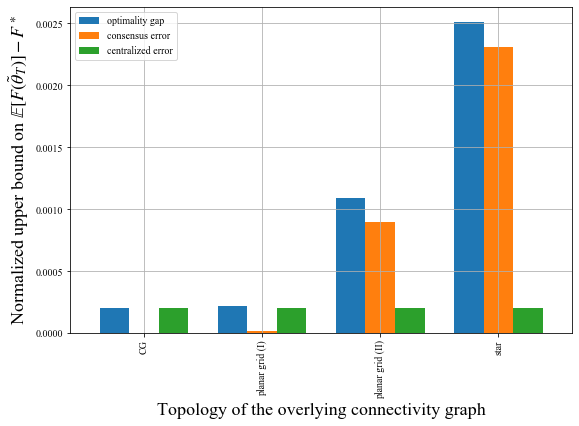

In [456]:
gb = 1
a = 1.3e8
barP = 2e-7
M = K
N = 10000
# opt = 0.41

T0 = 0
T1 = 5e3
T_array = np.arange(T1)
sT = np.cumsum((a+T_array)**2)
sT0 = sT[0] # the initial iteration used to evaluate the upper bounds for normalization
sT1 = sT[-1]
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))

og1_list = [] # store the optimality gap
og1_ini_list = [] # sotre the initial optimality gap
og1_partI = mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K)
og1_partI_list = [] # store the centralized error
og1_partII_list = [] # store the consensus error

# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta1 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta1 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega1 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta1,beta1,omega1), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta1,beta1,omega1) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta1,beta1,omega1) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta1,beta1,omega1) **2 * sT0) * gb**2 )


# Generate a 2-D torus (5-by-4, periodic)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega2 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta2,beta2,omega2), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta2,beta2,omega2) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta2,beta2,omega2) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta2,beta2,omega2) **2 * sT0) * gb**2 )


# Generate a 2-D torus (5-by-4, aperiodic)
G = net.grid_2d_graph(5, 4, periodic=False)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta3 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta3 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega3 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta3,beta3,omega3), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta3,beta3,omega3) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta3,beta3,omega3) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta3,beta3,omega3) **2 * sT0) * gb**2 )


# Generate a star graph
G = net.star_graph(reversed(range(K)))
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP
delta4 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta4 = np.linalg.norm(np.eye(K) - W, ord=2)

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega4 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
print(f'{a} | {max(5/p(delta4,beta4,omega4), 13 * L/mu)}')

og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T1) / (mu**2 * p(delta4,beta4,omega4) **2 * sT1) * gb**2 )

og1_partI_list.append( og1_partI )

og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta4,beta4,omega4) **2 * sT1) * gb**2 )

og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T0) / (mu**2 * p(delta4,beta4,omega4) **2 * sT0) * gb**2 )


# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
# E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
# alg_connect = E[1] 
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP
# delta5 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta5 = np.linalg.norm(np.eye(K) - W, ord=2)

# c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
# omega5 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
# print(f'{a} | {max(5/p(delta5,beta5,omega5), 13 * L/mu)}')

# og1_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT1 * a0 + \
# 1.625 * T1 * (T1 + 2 * a ) / (mu * sT1) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_partI_list.append( og1_partI )

# og1_partII_list.append( (158.45 * 24 * L * T1) / (mu**2 * p(delta5,beta5,omega5) **2 * sT1) * gb**2 )

# og1_ini_list.append( mu/3.25 * (a**3 - 3.25 * a **2) / sT0 * a0 + \
# 1.625 * T0 * (T0 + 2 * a ) / (mu * sT0) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T0) / (mu**2 * p(delta5,beta5,omega5) **2 * sT0) * gb**2 )

df1 = pd.DataFrame(columns = ['optimality gap', 'consensus error', 'centralized error'], 
                   index = ['CG', 'planar grid (I)', 'planar grid (II)', 'star'])
df1['optimality gap'] = np.array(og1_list) / np.array(og1_ini_list)
df1['consensus error'] = np.array(og1_partII_list) /np.array(og1_ini_list)
df1['centralized error'] = np.array(og1_partI_list) / np.array(og1_ini_list)
df1.plot.bar(width=0.75, ax = ax)

plt.xlabel(r'Topology of the overlying connectivity graph', fontsize = 18)
plt.ylabel(r'Normalized upper bound on $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
# plt.xlim((0, 5000))
# plt.ylim((0, 1))
plt.grid()

# # Place legend for individual curves
# plt.legend(loc = 'upper right', fontsize = 14)

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_topology_large_T.eps',format='eps', dpi=600)
plt.show()

In [454]:
df1

,optimality gap,consensus error,centralized error
CG,0.000200,3.578928e-07,0.0002
planar grid (I),0.000213,1.331536e-05,0.0002
planar grid (II),0.001093,8.929063e-04,0.0002
star,0.002511,2.311496e-03,0.0002


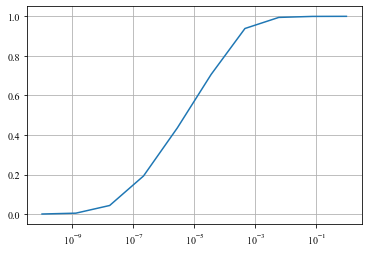

In [285]:
barP_array = np.logspace(-10,0,10)
omega_array = np.zeros(barP_array.shape)
N = 3e5
for i in range(len(barP_array)):
    barP = barP_array[i]
    omega_array[i] = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
    
_, = plt.semilogx(barP_array,  omega_array)
plt.grid()

In [369]:
min

0.3071035580555791

In [370]:
beta

1.692896441944421

In [419]:
5 / p(delta, beta, omega)

1672.628095871042

**Evaluate the emprical optimality gap of $F({\bar{\theta}}^{(t)}) - F^\ast$ with varying $\rho$**

In [434]:
opt = 0.41
losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_1_a_200.00_zeta0_0.0005_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
K = losseses.shape[2]
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.0020mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.00002mW_N_7943_a_200.00_zeta0_0.0005_a_prime_100.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.000004mW_N_7943_a_200.00_zeta0_0.0005_a_prime_200.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df4 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.000002mW_N_7943_a_200.00_zeta0_0.0005_a_prime_200.00_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df5 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/simulations/losseses_SCHEME_2_P_0.000002mW_N_7943_a_200.00_zeta0_0.0005_a_prime_200.00_2-D_torus.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df6 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_local_a_200.00.pkl', 'rb') )
losseses = np.array(losseses) - opt
df8 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


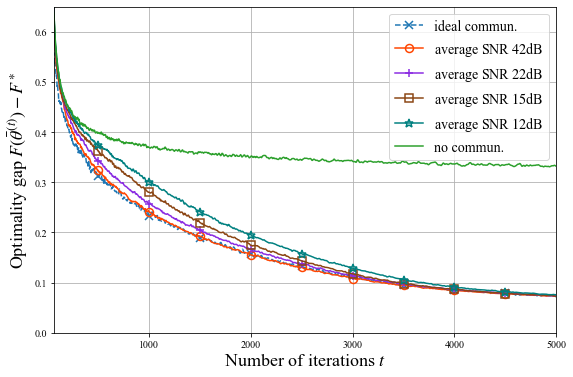

In [458]:
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))
# "mew" stands for markedgewidth, which is supposed to be set equal to the width of the line
df1.rolling(window = 20).mean().mean(axis = 1).plot(style = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')
df2.rolling(window = 49).mean().mean(axis = 1).plot(color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'average SNR $42$dB')
df3.rolling(window = 49).mean().mean(axis = 1).plot(color = 'blueviolet', marker = '+', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'average SNR $22$dB')
df4.rolling(window = 49).mean().mean(axis = 1).plot(color = 'saddlebrown', marker = 's', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'average SNR $15$dB')
df5.rolling(window = 49).mean().mean(axis = 1).plot(color = 'teal', marker = '*', fillstyle = 'none', ms = 9, mew = 1.5, markevery = 500, label = r'average SNR $12$dB')
# df6.rolling(window = 30).mean().mean(axis = 1).plot(color = 'tab:blue', label = r'average SNR $8$dB')
# df7.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
df8.rolling(window = 49).mean().mean(axis = 1).plot(color = 'tab:green', label = 'no commun.')

plt.xlabel(r'Number of iterations $t$', fontsize = 18)
plt.ylabel(r'Optimality gap $F(\bar{\theta}^{(t)})-F^\ast$', fontsize = 18)
# plt.title(r'ER graph with $p = 0.2$ and $\barP = -57$dBm', fontsize = 14)
plt.xlim((65, 5000))
plt.ylim((0, 0.65))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# # Place marks using annotation
# _ = ax.annotate(r'Ideal communications',
#             xy = (1400, .08), xycoords = 'data',
#             xytext = (-30, -32), textcoords = 'offset points', fontsize = 16,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
# _ = ax.annotate(r'Digital transmission',
#             xy = (2200, .06), xycoords = 'data',
#             xytext = (36, 28), textcoords = 'offset points', fontsize = 16,
#             arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# _ = plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_og_vs_SNR.eps',format='eps', dpi=600)
plt.show()

In [448]:
df8.rolling(window = 49).mean().mean(axis = 1)[65]

0.6326127022626459

In [358]:
temp.lines[4].get_markeredgewidth()

1.0

**Evaluate the emprical optimality gap of $F({\bar{\theta}}^{(t)}) - F^\ast$ with or w/o the digital scheduling policy**

In [11]:
opt = 0.41
losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_1_a_200.00_zeta0_0.0005_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
K = losseses.shape[2]
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.000020mW_N_20000_a_200.00_zeta0_0.0005_a_prime_200.00_chain.pkl', 'rb') )
losseses = np.array(losseses) - opt
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_3_P_0.000020mW_N_20000_a_200.00_zeta0_0.0005_a_prime_200.00_chain.pkl', 'rb') )
losseses = np.array(losseses) - opt
df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_2_P_0.000020mW_N_1000_a_200.00_zeta0_0.0005_a_prime_200.00_chain.pkl', 'rb') )
losseses = np.array(losseses) - opt
df4 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_3_P_0.000020mW_N_1000_a_200.00_zeta0_0.0005_a_prime_200.00_chain.pkl', 'rb') )
losseses = np.array(losseses) - opt
df5 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('../repo_jv/data/simulations/losseses_SCHEME_4_P_0.000200mW_N_1000_a_200.00_zeta0_0.0005_a_prime_1000.00_chain_equal_n-1.pkl', 'rb') )
# losseses = np.array(losseses[1]) - opt
# df6 = pd.DataFrame(losseses, columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('../repo_jv/data/losseses_SCHEME_1_eta0_2.00_zeta0_1.00_10-0.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('../repo_jv/data/simulations/losseses_local_a_200.00.pkl', 'rb') )
losseses = np.array(losseses) - opt
df8 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

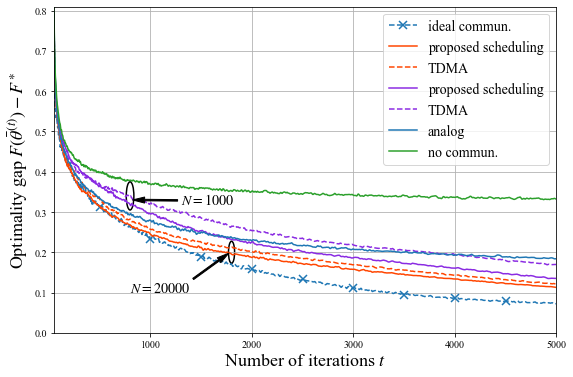

In [13]:
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))
df1.rolling(window = 20).mean().mean(axis = 1).plot(style = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'ideal commun.')
df2.rolling(window = 49).mean().mean(axis = 1).plot(color = 'orangered', label = r'proposed scheduling')
df3.rolling(window = 49).mean().mean(axis = 1).plot(style = '--', color = 'orangered', label = r'TDMA')
df4.rolling(window = 49).mean().mean(axis = 1).plot(color = 'blueviolet', label = r'proposed scheduling')
df5.rolling(window = 49).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = r'TDMA')
# df6.rolling(window = 49).mean().mean(axis = 1).plot(color = 'tab:blue', label = r'analog')
# df7.rolling(window = 10).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', label = 'Ideal commun.')
df8.rolling(window = 49).mean().mean(axis = 1).plot(color = 'tab:green', label = 'no commun.')

plt.xlabel(r'Number of iterations $t$', fontsize = 18)
plt.ylabel(r'Optimality gap $F(\bar{\theta}^{(t)})-F^\ast$', fontsize = 18)
# plt.title(r'ER graph with $p = 0.2$ and $\barP = -57$dBm', fontsize = 14)
plt.xlim((51, 5000))
plt.ylim((0, 0.81))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
from matplotlib.patches import Ellipse
el = Ellipse((800, 0.34), 75, 0.070, angle = 0, fill = False, lw = 1.5)
ax.add_artist(el)
el = Ellipse((1800, 0.20), 60, 0.055, angle = 0, fill = False, lw = 1.5)
ax.add_artist(el)
_ = ax.annotate(r'$N = 1000$',
            xy = (810, .33), xycoords = 'data',
            xytext = (50, -5), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 1.5, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'$N = 20000$',
            xy = (1785, .2), xycoords = 'data',
            xytext = (-100, -40), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 1.5, headwidth = 6, shrink = 0.03))

# _ = plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_scheduling-vs_TDMA.eps',format='eps', dpi=600)
plt.show()

In [9]:
df4.rolling(window = 49).mean().mean(axis = 1).min() + opt

0.5448579172394723

In [1]:
el.get_linewidth()

NameError: name 'plt' is not defined

**Evaluate the analytical upper-bound for $F({\bar{\theta}}^{(t)}) - F^\ast$ under varying topologies**

C:\Users\Helen\.conda\envs\dsgd\lib\site-packages\ipykernel_launcher.py:217: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


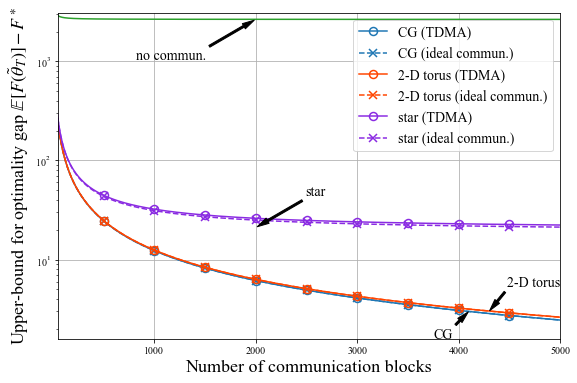

In [710]:
a = 1e6
M = K # the chromatic number for the digital scheme
N = 3200000
# opt = 0.41
barP = 2e-7
# d_min = 50
# d_max = 200
D = 125 * np.ones((K, K)) # mimic the effect of the same pathloss

Tmax = 5e3
T_array = np.arange(1,Tmax)
sT = np.cumsum((a+T_array)**2)
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))


# Generate a complete graph
G = net.complete_graph(K)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega1 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
delta1 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta1 = np.linalg.norm(np.eye(K) - W, ord=2)
p1 = p(delta1,beta1,omega1)
og1 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p1 **2 * sT) * gb**2
plt.semilogy(T_array, og1, marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'CG (TDMA)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta1,beta1,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og, color = 'C0', ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'CG (ideal commun.)')


# Generate a 2-D torus (5-by-4)
G = net.grid_2d_graph(5, 4, periodic=True)
mapping = {(m,n):4*m+n for m, n in G.nodes()}
_ = net.relabel_nodes(G, mapping, copy=False)
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega2 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
delta2 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta2 = np.linalg.norm(np.eye(K) - W, ord=2)
p2 = p(delta2,beta2,omega2)
og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p2 **2 * sT) * gb**2
plt.semilogy(T_array, og2, color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'2-D torus (TDMA)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta2,beta2,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og, color = 'orangered', ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'2-D torus (ideal commun.)')


# # Generate a chain-graph based ER graph with p=0.5
# seeds = iter(range(1000))
# prob = 0.5
# alg_connect = 0
# while alg_connect < 1e-4:
#     # Generate a chain (cycle) graph
#     G = net.cycle_graph(K)
#     G.remove_edge(0, K-1)
#     # Base an ER graph on the chain graph with prob. p to improve the spectral gap delta
#     ER = net.erdos_renyi_graph(K, prob, seed = next(seeds))
#     G.add_edges_from(ER.edges())
#     LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
#     E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
#     alg_connect = E[1]
    
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP

# np.random.seed(2)
# omega_array = []
# # Set distances among any pair of nodes for around 10 times to average out the impact of distance on topologies
# for n in range(5):
#     rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
#     theta = 2 * np.pi * np.random.rand(K,1)
#     # D = np.ones((K, K))
#     D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
#     c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)] # The c_array used for funcG obeys "laziness"
#     omega_array.append (min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) ))

# omega = sum(omega_array) / 5
# delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta = np.linalg.norm(np.eye(K) - W, ord=2)
# og2 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og2 - opt, color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'ER graph (digital)')
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og - opt, color = 'orangered', ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'ER Graph (ideal)')

# # Generate a chain-graph based ER graph with p=0.1
# seeds = iter(range(1000))
# prob = 0.1
# alg_connect = 0
# while alg_connect < 1e-4:
#     # Generate a chain (cycle) graph
#     G = net.cycle_graph(K)
#     G.remove_edge(0, K-1)
#     # Base an ER graph on the chain graph with prob. p to improve the spectral gap delta
#     ER = net.erdos_renyi_graph(K, prob, seed = next(seeds))
#     G.add_edges_from(ER.edges())
#     LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
#     E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
#     alg_connect = E[1]
    
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP

# np.random.seed(2)
# omega_array = []
# # Set distances among any pair of nodes for around 10 times to average out the impact of distance on topologies
# for n in range(5):
#     rho =  d_min + (d_max - d_min) * np.random.rand(K,1) 
#     theta = 2 * np.pi * np.random.rand(K,1)
#     # D = np.ones((K, K))
#     D = np.sqrt(rho ** 2 + rho.T ** 2 - 2 * (rho @ rho.T) * np.cos(theta - theta.T))
#     c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)] # The c_array used for funcG obeys "laziness"
#     omega_array.append (min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) ))

# omega = sum(omega_array) / 5
# delta = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta = np.linalg.norm(np.eye(K) - W, ord=2)
# og3 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og3 - opt, color = 'blueviolet', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'ER graph (digital)')
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta,beta,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og - opt, color = 'blueviolet', ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'ER graph (ideal)')


# Generate a star graph
G = net.star_graph(reversed(range(K)))
LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
alg_connect = E[1] 
alpha = 2 / (E[K-1] + E[1])
W = np.eye(K) - alpha * LP

c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
omega3 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
delta3 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
beta3 = np.linalg.norm(np.eye(K) - W, ord=2)
p3 = p(delta3,beta3,omega3)
og3 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p3 **2 * sT) * gb**2
plt.semilogy(T_array, og3, color = 'blueviolet', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'star (TDMA)')
# ideal communication with the estimation quality omega = 1
omega = 1
og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
(158.45 * 24 * L * T_array) / (mu**2 * p(delta3,beta3,omega) **2 * sT) * gb**2
plt.semilogy(T_array, og,  color = 'blueviolet', ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'star (ideal commun.)')

# # Generate a chain (cycle) graph
# G = net.cycle_graph(K)
# G.remove_edge(0, K-1)
# LP = np.array(net.laplacian_matrix(G, nodelist = range(K)).todense())
# E, _ = np.linalg.eigh(LP) # eigenvalues are assumed given in an ascending order
# alg_connect = E[1] 
# alpha = 2 / (E[K-1] + E[1])
# W = np.eye(K) - alpha * LP

# c_array = [ sum((D[i,j] / d0) ** gamma  for j in G[i]) for i in range(K)]
# omega4 = min( 1./d + sum(funcG(barP, M, N, n, i) for n in range(2,d+1)) / d for i in range(K) )
# delta4 = 1 - np.linalg.norm(np.ones((K,K)) / K - W, ord=2)
# beta4 = np.linalg.norm(np.eye(K) - W, ord=2)
# p4 = p(delta4,beta4,omega4)
# og4 = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p4**2 * sT) * gb**2
# plt.semilogy(T_array, og4, color = 'saddlebrown', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'chain (TDMA)')
# # ideal communication with the estimation quality omega = 1
# omega = 1
# og = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
# 1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) + \
# (158.45 * 24 * L * T_array) / (mu**2 * p(delta3,beta3,omega) **2 * sT) * gb**2
# plt.semilogy(T_array, og, color = 'saddlebrown', ls = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label=r'chain (ideal commun.)')


# no communication with bounded consensus error derived as a result of (expected) norm bound for gradients
ogLocal = mu/3.25 * (a**3 - 3.25 * a **2) / sT * a0 + \
1.625 * T_array * (T_array + 2 * a ) / (mu * sT) * (bar_sigma_sqr / K) +\
1.5 * L * (1 + 1./K)**2 * (4 / mu**2) * gb**2
plt.semilogy(T_array, ogLocal, color = 'tab:green')

plt.xlabel(r'Number of communication blocks', fontsize = 18)
plt.ylabel(r'Upper-bound for optimality gap $\mathbb{E}[F(\tilde{\theta}_T)]-F^\ast$', fontsize = 18)
# plt.title(r'$\lambda_2(L) = 8$')
plt.xlim((50, 5000))
plt.ylim((0, 3100))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'no commun.',
            xy = (2000, 2653), xycoords = 'data',
            xytext = (-120, -40), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'star',
            xy = (2000, 21), xycoords = 'data',
            xytext = (50, 32), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'CG',
            xy = (4100, 3.00), xycoords = 'data',
            xytext = (-35, -27), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'2-D torus',
            xy = (4300, 3.0), xycoords = 'data',
            xytext = (18, 25), textcoords = 'offset points', fontsize = 14,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_ub_og_vs_topology.eps',format='eps', dpi=600)
plt.show()

In [553]:
p1

0.029073157873151102

In [554]:
p(delta1,beta1,1)

0.0333333333333333

In [555]:
p2

0.002920939814220538

In [556]:
p(delta2,beta2,1)

0.0029893076723646614

In [683]:
p3

0.00027617778031484785

In [684]:
p(delta3,beta3,1)

0.00028389887792348005

In [701]:
og1[4100]

2.990416644733825

In [594]:
ogLocal[49]

2893.7943240252903

**Evaluate the emprical optimality gap of $F({\bar{\theta}}^{(t)}) - F^\ast$ under different topologies**

In [5]:
# K = losseses.shape[2]
opt = 0.41
losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_a_200.00_zeta0_0.0005_CG.pkl', 'rb') )
losseses = np.array(losseses) - opt
df1 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_a_200.00_zeta0_0.0005_2-D_torus.pkl', 'rb') )
losseses = np.array(losseses) - opt
df2 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_SCHEME_1_a_200.00_zeta0_0.0005_star.pkl', 'rb') )
losseses = np.array(losseses) - opt
df3 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = []
TrialNum = 10
for nth in range(TrialNum):
    temp = pickle.load( open('./data/simulations/losseses_SCHEME_3_P_0.000200mW_N_20000_a_200.00_zeta0_0.0005_a_prime_6.00_CG_equal_n-{:d}.pkl'.format(nth), 'rb') )
    losseses.append(temp[nth])
losseses = np.array(losseses[:TrialNum]) - opt
df4 = pd.DataFrame(losseses.mean(axis = 0), columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = []
# TrialNum = 10
for nth in range(TrialNum):
    temp = pickle.load( open('./data/simulations/losseses_SCHEME_3_P_0.000200mW_N_20000_a_200.00_zeta0_0.0005_a_prime_6.00_torus_equal_n-{:d}.pkl'.format(nth), 'rb') )
    losseses.append(temp[nth])
losseses = np.array(losseses[:TrialNum]) - opt
df5 = pd.DataFrame(losseses.mean(axis = 0), columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = []
# TrialNum = 10
for nth in range(TrialNum):
    temp = pickle.load( open('./data/simulations/losseses_SCHEME_3_P_0.000200mW_N_20000_a_200.00_zeta0_0.0005_a_prime_6.00_star_equal_n-{:d}.pkl'.format(nth), 'rb') )
    losseses.append(temp[nth])
losseses = np.array(losseses[:TrialNum]) - opt
df6 = pd.DataFrame(losseses.mean(axis = 0), columns = ['Device_{}'.format(i + 1) for i in range(K)] )

# losseses = pickle.load( open('./data/simulations/losseses_SCHEME_3_P_0.000200mW_N_20000_a_200.00_zeta0_0.0005_a_prime_200.00_star_equal.pkl', 'rb') )
# losseses = np.array(losseses) - opt
# df7 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

losseses = pickle.load( open('./data/simulations/losseses_local_a_200.00.pkl', 'rb') )
losseses = np.array(losseses) - opt
df8 = pd.DataFrame(losseses[0], columns = ['Device_{}'.format(i + 1) for i in range(K)] )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


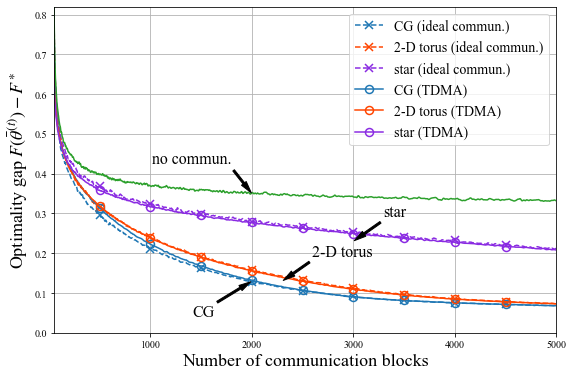

In [7]:
plt.rc('font', family='Times New Roman')
mpl.rcParams["mathtext.fontset"] = 'stix'
fig, ax = plt.subplots(figsize = (9.0,6.0))
df1.rolling(window = 49).mean().mean(axis = 1).plot(style = '--', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'CG (ideal commun.)')
df2.rolling(window = 49).mean().mean(axis = 1).plot(style = '--', color = 'orangered', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'2-D torus (ideal commun.)')
df3.rolling(window = 49).mean().mean(axis = 1).plot(style = '--', color = 'blueviolet', marker = 'x', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'star (ideal commun.)')
df4.rolling(window = 29).mean().mean(axis = 1).plot(color = 'C0', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'CG (TDMA)')
df5.rolling(window = 29).mean().mean(axis = 1).plot(color = 'orangered', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'2-D torus (TDMA)')
df6.rolling(window = 29).mean().mean(axis = 1).plot(color = 'blueviolet', marker = 'o', fillstyle = 'none', ms = 8, mew = 1.5, markevery = 500, label = r'star (TDMA)')
# df7.rolling(window = 10).mean().mean(axis = 1).plot(color = 'saddlebrown', label = 'Ideal commun.')
df8.rolling(window = 49).mean().mean(axis = 1).plot(color = 'tab:green', label = '')
plt.xlabel(r'Number of communication blocks', fontsize = 18)
plt.ylabel(r'Optimality gap $F(\bar{\theta}^{(t)})-F^\ast$', fontsize = 18)
# plt.title(r'ER graph with $p = 0.2$ and $\barP = -57$dBm', fontsize = 14)
plt.xlim((50, 5000))
plt.ylim((0, 0.82))
plt.grid()

# Place legend for individual curves
plt.legend(loc = 'upper right', fontsize = 14)
# Place marks using annotation
_ = ax.annotate(r'no commun.',
            xy = (2000, .35), xycoords = 'data',
            xytext = (-100, 30), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'star',
            xy = (3000, .23), xycoords = 'data',
            xytext = (30, 25), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'CG',
            xy = (2000, .13), xycoords = 'data',
            xytext = (-60, -35), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))
_ = ax.annotate(r'2-D torus',
            xy = (2300, .13), xycoords = 'data',
            xytext = (30, 25), textcoords = 'offset points', fontsize = 16,
            arrowprops=dict(facecolor = 'black', width = 2, headwidth = 6, shrink = 0.03))

# _ = plt.savefig('C:/Users/Helen/Documents/visiting_research@KCL/D2D_DSGD/XXX20-FL_over_D2D/eps/dig_og_vs_topology.eps',format='eps', dpi=600)
plt.show()

In [638]:
df3.rolling(window = 49).mean().mean(axis = 1).min() + opt

0.6200366636320046

In [723]:
df1.rolling(window = 49).mean().mean(axis = 1)[2000]

0.12883247579238952